In [ ]:
%load_ext autoreload
%autoreload 2

# General
import pynwb
import numpy as np
import pandas as pd
import networkx as nx

# Local
from nwb_query import TimeIntervals as TI
from nwb_query import ContinuousData, PointData, EventData, TimeIntervals, plot_PointData_multiple, plot_ContinuousData, plot_EventData
import fl_apparatus as ap


# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'lines.solid_capstyle': 'butt'})
mdates.rcParams.update({'date.autoformatter.microsecond': '%H:%M:%S.%f'})

### Todo
Next up:
- ContinuousData using pandas
    - require column names (derive them from NWB, or schema docs!, if possible)

Prettify notebook:
  - Make plots to capture TimeQuery (original data, TimeIntervals, result)
  - Add valid_intervals to legends of plots
  - Add `__repr__` methods for classes and get rid of multiline print statements

Plumbing:
- Make ContinuousData and PointProcess iterable by interval (return single interval and its data)
    -add tags as labels to plots
- use pynwb.TimeIntervals (exercise using pynwb datatypes)
- add valid_intervals to pynwb.TimeSeries
- use pynwb.TimeSeries as base class for ContinuousData, PointData, EventData
- ? Subclass PointProcess for spiking data (include other columns: clustering metadata, e.g.)
- ? Subclass ContinuousData for Behavioral data (include SI units, samplerate?)
- Investigate xarray for ContinuousData, etc.

Usage:
- query spiking b
y epoch before doing behavior selection
- behavior (position/speed) should be a time_query (using epoch tq), and not epoch name
    - requires concatenating behav on import

Analysis:
- write occupancy function


### Data import and analysis parameters

In [2]:
# what data to analyze
d = {}
d['anim'] = 'Bon'
d['day'] = 5 # 1-indexed

d['epoch'] = 1 # 1-indexed
d['cluster_id'] = 30

# analysis configuration
c = {}
c['speed_threshold'] = 0.05 # m/s

### Read NWB file

In [3]:
animday = '{}{:02d}'.format(d['anim'], d['day'])
nwb_filename = './' + animday + '_test.nwb'

print('Loading file: %s' % nwb_filename)
io = pynwb.NWBHDF5IO(nwb_filename, mode='r')
nwbf = io.read()
 
sst = nwbf.session_start_time.timestamp()

### Dataset Query: position of animal during all sleep epochs

In [4]:
sleep_epochs = [i+1 for i in np.where(nwbf.epochs['epoch_type'][:] == 'sleep')[0]] # epochs are 1-indexed
all_sleep_pos = {}
for sleep_epoch in sleep_epochs:
    position_module_name = 'Position d{:d} e{:d}'.format(d['day'], sleep_epoch) # HACKY--we should query on epoch directly
    position_h5py = nwbf.modules['Behavior']['Position'][position_module_name]
    position_data = pd.DataFrame(data=position_h5py.data[()], columns=['x', 'y'])
    all_sleep_pos[sleep_epoch] = ContinuousData(samples=position_data, sample_times=position_h5py.timestamps[()])

### Plot animal positions during sleep epochs, overlaid on the sleep box
Use Network X to extract and plot the sleep box geometry.

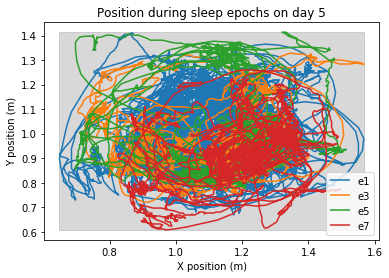

In [8]:
# Plot position of the animal during each sleep epoch
plt.figure()
plt.title('Position during sleep epochs on day {}'.format(d['day']))
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
ax = plt.subplot(111)
for epoch, sleep_pos in all_sleep_pos.items():
    plt.plot(sleep_pos.samples['x'], sleep_pos.samples['y'], marker='', label='e{}'.format(epoch))

# Get the Sleep Box apparatus (Same apparatus for all sleep epochs, so just use the first)
first_sleep_epoch = sleep_epochs[0] - 1  # epochs table is 0-indexed
appar = nwbf.epochs['task'][first_sleep_epoch].apparatus

# Convert the Frank Lab apparatus to a Network X graph and plot it
H = nx.Graph(name='w-track test')
for n in appar.nodes.values():
    ap.add_fl_node_to_nx_graph(n, H)
ap.plot_nx_appar_geom(H, ax)
ax.legend()
pass

### Dataset Query: speed of a given animal, day, and epoch
#### NWBFile (one animal), day, epoch --> ContinuousData (speed)

In [ ]:
speed_module_name = 'Speed d{:d} e{:d}'.format(d['day'], d['epoch']) # HACKY--we should query on epoch directly
speed_h5py = nwbf.modules['Behavior']['Speed'][speed_module_name]
samples = pd.DataFrame(data=speed_h5py.data[()], columns=['speed'])
speed = ContinuousData(samples=samples, sample_times=speed_h5py.timestamps[()])
speed.valid_intervals

In [ ]:
print(nwbf.__repr__())

### Dataset Query: position of a given animal, day, and epoch
#### NWBFile (one animal), day, epoch --> ContinuousData (position)

In [ ]:
position_module_name = 'Position d{:d} e{:d}'.format(d['day'], d['epoch']) # HACKY--we should query on epoch directly
position_h5py = nwbf.modules['Behavior']['Position'][position_module_name]
# position_data = np.array(position_h5py.data[()])
position_data = pd.DataFrame(data=position_h5py.data[()], columns=['x', 'y'])
position = ContinuousData(position_data, position_h5py.timestamps[()])

print('*** All position records for epoch ***')
print('# of measurements = %d' % position.samples.shape[0])
print('# of intervals = %d' % len(position.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(position.valid_intervals.durations()))

fig1 = plt.figure(1, figsize=(15,3))
ax1 = fig1.add_subplot(1, 1, 1)
plot_ContinuousData(position)

### Dataset Query: spiking of a given animal and cluster
#### NWBFile (one animal), cluster --> PointData (spiking)

In [ ]:
spikes_t = nwbf.units['spike_times'][d['cluster_id']]
valid_intervals = TimeIntervals(nwbf.units['obs_intervals'][d['cluster_id']])
spiking_all = PointData(point_times=spikes_t, valid_intervals=valid_intervals)

print('*** Spiking for cluster %s ***' % d['cluster_id'])
print('# of spikes = %d' % spiking_all.point_times.shape[0])
print('# of intervals = %d' % len(spiking_all.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_all.valid_intervals.durations()))

### Time Query: Find spiking within all non-sleep epochs
#### PointData (spiking), TimeIntervals (epochs) --> PointData (spiking)

The resulting valid_intervals for spiking are the intersection of the valid_intervals for spiking data and the time intervals defining the non-sleep behavioral epochs. Presently, the epoch start/stop times are inferred from the behavioral data, as epoch start/stop times are not explicitly defined in FrankLab data structures. 

In [ ]:
# Get start/stop times for all non-sleep behavioral epochs (called 'run' epochs in FrankLab data)
epoch_types = np.array(nwbf.epochs['epoch_type'][:])
behav_epoch_indices = np.where(epoch_types=='run')[0]

# Build a TimeIntervals query with start/stop times of non-sleep behavioral epochs
behav_intervals = []
for i in behav_epoch_indices:
    epoch_start = nwbf.epochs['start_time'][i]
    epoch_stop = nwbf.epochs['stop_time'][i]
    behav_intervals.append([epoch_start, epoch_stop])
behav_intervals = TimeIntervals(np.array(behav_intervals)) # convert to TimeIntervals for query

# time_query on spiking during non-sleep behavioral epochs
spiking_behav = spiking_all.time_query(behav_intervals)

print('*** Spiking for cluster %s during non-sleep behavioral epochs ***' % d['cluster_id'])
print('# of spikes = %d' % spiking_behav.point_times.shape[0])
print('# of intervals = %d' % len(spiking_behav.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_behav.valid_intervals.durations()))

# Plot spiking
spikeplots = [(spiking_all, 'All spiking'),
              (spiking_behav, 'Spikes in\nnon-sleep epochs')]

fig1 = plt.figure(1, figsize=(15,3))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)

pass # suppress output
    


### Time Query: Find spiking within a single behavioral epoch
#### PointData (spiking), TimeIntervals (epoch) --> PointData (spiking)

In [ ]:
# Get epoch start/stop times from the NWB file
epoch_start = nwbf.epochs['start_time'][d['epoch']-1]
epoch_end = nwbf.epochs['stop_time'][d['epoch']-1]
epoch_interval = TimeIntervals(np.array([epoch_start, epoch_end]))

# time_query on spiking during the epoch
spiking = spiking_all.time_query(epoch_interval)

print('*** Spiking for cluster %s during epoch %d ***' % (d['cluster_id'], d['epoch']))
print('# of spikes = %d' % spiking.point_times.shape[0])
print('# of intervals = %d' % len(spiking.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking.valid_intervals.durations()))


# Plot spiking
spikeplots = [(spiking_all, 'All spiking'),
              (spiking_behav, 'Spikes in\nnon-sleep epochs'),
              (spiking, 'Spikes in\nepoch %s' % d['epoch'])]

fig1 = plt.figure(1, figsize=(15,3))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)

fig2 = plt.figure(2, figsize=(15,2))
ax2 = fig2.add_subplot(1, 1, 1)
plot_PointData_multiple([spikeplots[2]], axis=ax2)
ax2.set_title("Zooming in...")

pass # suppress output

### Analysis: Find time intervals where speed > threshold
#### ContinuousData (speed), lambda function --> EventData (time periods where animal speed > threshold)
This is an _analysis_, not a query, because we are not simply selecting a subset of a given datatype. i.e. We are not asking for a subset of the speed data, but rather for the intervals where it fulfills a lambda function. The lambda function could have been something different, like "find the times of all upward threshold crossings, and then pad this by 5 seconds on either side.". Regardless of how simple or complex the lambda function is, we consider this to be an analysis. Using the output of this to select a subset of the spiking data, however, is a query.

In [ ]:
speed_threshold_fn = lambda x: x > c['speed_threshold']
speed_events = speed.filter_intervals(speed_threshold_fn)

print('*** Times where speed > threshold ***')
print('# of events = %d' % len(speed_events.event_intervals))
print('duration of events = %0.2f s' % np.sum(speed_events.durations()))
print('# of valid intervals = %d' % len(speed_events.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(speed_events.valid_durations()))

# TODO: Plot continuous speed
fig1 = plt.figure(1, figsize=(15.5,1.5))
ax1 = fig1.add_subplot(1, 1, 1)
plot_EventData(speed_events, axis=ax1)
ax1.set_yticks([1])
ax1.set_yticklabels(['Run events \n(speed>threshold)']) # eventually use metadata from PointData object
pass # suppress output

### Query: spiking during time intervals where speed > threshold
#### PointData (spiking), EventData (bouts where speed > threshold) --> PointData (spiking)

In [ ]:
spiking_run = spiking.time_query(speed_events)  # Use the built-in time query method on PointProcess

print('*** Spiking where speed > threshold ***')
print('# of spikes = %d' % len(spiking_run.point_times))
print('# of intervals = %d' % len(spiking_run.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_run.valid_intervals.durations()))
print()

print(spiking_run)

# Plot spiking
fig1 = plt.figure(1, figsize=(15,1.5))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple([(spiking_run, 'Spiking during\nrun events')], axis=ax1)

pass # suppress output

### Analysis: Mark animal position at the time of each spike
#### PointData (spiking), ContinuousData (position [m x 2]) --> PointData with marks (spike times with associated positions)

In [ ]:
spiking_run_mark_pos = spiking_run.mark_with_ContinuousData(position)

print('*** Spiking where speed > threshold, marked with position ***')
print('# of marked spikes = %d' % len(spiking_run_mark_pos.point_times))
print('# of intervals = %d' % len(spiking_run_mark_pos.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_run_mark_pos.valid_intervals.durations()))
print()

### Query: Get animal locations during running events
#### ContinuousData (position [m x 2]), EventData (bouts where speed > threshold) --> ContinuousData (position [m_new x 2])

In [ ]:
position_run = position.time_query(speed_events)

print('*** Position where speed > threshold ***')
print('# of samples = %d' % position_run.samples.shape[0])
print('# of intervals = %d' % len(position_run.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(position_run.valid_intervals.durations()))
print()

fig1 = plt.figure(1, figsize=(15,8))
ax1 = fig1.add_subplot(4, 1, 1)
ax1.set_title('Position (m)', fontsize=15)
plot_ContinuousData(position, axis=ax1)
ax1.label_outer()

ax2 = fig1.add_subplot(4, 1, 2, sharex=ax1)
ax2.set_title('Speed (m/s)', fontsize=15)
plot_ContinuousData(speed, axis=ax2)
ax2.set_xlabel('')
ax2.label_outer()

ax3 = fig1.add_subplot(4, 1, 3, sharex=ax1)
ax3.set_title('Intervals where speed > threshold', fontsize=15)
plot_EventData(speed_events, axis=ax3)
ax3.label_outer()

ax4 = fig1.add_subplot(4, 1, 4, sharex=ax1)
ax4.set_title('Position (m) during intervals where speed > threshold ', fontsize=15)
plot_ContinuousData(position_run, axis=ax4)

print(position.sample_times[0])
ax1.set_xlim(1136409500, 1136409600)

plt.tight_layout()

pass

### Plot spikes by location

In [ ]:
fig1 = plt.figure(1, figsize=(15,15))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.axis('equal')


task = nwbf.epochs['task'][d['epoch']-1]  # The task for this epoch
appar = task.apparatus
H = nx.Graph(name='w-track test')
for n in appar.nodes.values():
    ap.add_fl_node_to_nx_graph(n, H)
for e in appar.edges.values():
    n1, n2 = e.edge_nodes
    H.add_edge(n1, n2)
ap.plot_nx_appar_geom(H, ax1)

# Line showing the animal's movement during the entire epoch
plt.plot(position.samples['x'], position.samples['y'], marker='', color='gray', label='Rat location', zorder=1)

# Lines showing animal movement during each interval where it was running
run_label = 'Rat location during movement'
for ivl in position_run.valid_intervals:
    ivl_data = position.time_query(TimeIntervals(ivl)).samples  # position at this valid interval 
    plt.plot(ivl_data['x'], ivl_data['y'], marker='', color='red', label=run_label, zorder=2)
    run_label = '_' # omit later lines from legend

# Markers for locations where unit spiked during animal running
plt.scatter(spiking_run_mark_pos.marks['x'], spiking_run_mark_pos.marks['y'], marker='D', s=50, label='Location at spike times during movement', zorder=3)

ax1.legend()
ax1.set_xlabel('X position (m)')
ax1.set_ylabel('Y position (m)')
ax1.set_title('Spike-position map for {} d{} e{} c{}, speed > {:0.1f} cm/s, task: {}'.format(d['anim'], d['day'], d['epoch'], 
                                                                                             d['cluster_id'], (c['speed_threshold'] * 100), task.name))

pass

In [ ]:
for e in appar.edges.values():
    print(e)

In [ ]:
io.close()